# Examples of XAI-Lib Usage for image data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
assert tf.__version__[0]=='2', 'please install tensorflow 2.x'

In [2]:
# Load data
imagenet_x_data = pickle.load(open('./datasets/imagenet.p','rb'))
imagenet_y_data = pickle.load(open('./datasets/imagenet_labels.p','rb'))
imagenet_map = pickle.load(open('./datasets/imagenet_mapping_labels.p','rb'))

# Load Model
imagenet_VGG = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
imagenet_VGG.trainable = False
imagenet_VGG.summary()

2021-09-30 11:51:17.075709: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-30 11:51:17.076348: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
pred = np.argmax(imagenet_VGG(imagenet_x_data[0,:].reshape(1,224,224,3)).numpy())

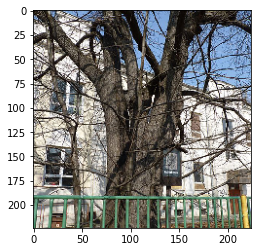

In [4]:
plt.imshow(imagenet_x_data[0,:].astype(int))

In [5]:
imagenet_map['716']

['n03930313', 'picket_fence']

## Intgrad

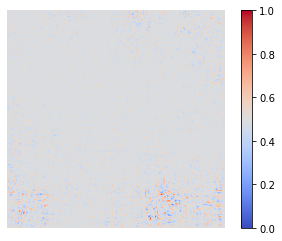

In [53]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(imagenet_VGG)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
image = imagenet_x_data[0,:]

# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return tf.convert_to_tensor(image,dtype=tf.float32)

# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return tf.nn.softmax(imagenet_VGG(image), axis=-1)

# 5) Explain an Instance
scores = ig.explain(image, pred, 'black', preprocessing, predict, model_type='tensorflow')

s = np.sum(scores,axis=-1)
plt.imshow((s+np.abs(np.min(s)))/(np.max(s)-np.min(s)),cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## RISE

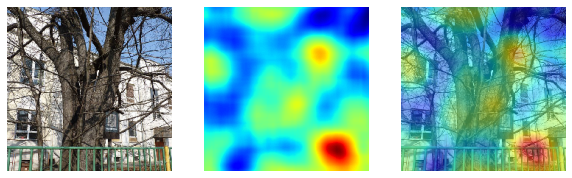

In [8]:
from xailib.explainers.rise_explainer import RiseXAIImageExplainer

class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size
        
    def predict(self, X):
        return self.model.predict(X)
        

model = Rise_model_wrapper(imagenet_VGG, (224,224))
rise = RiseXAIImageExplainer(model)
        
fig, ax = plt.subplots(1,3,figsize=(10,5))
img = imagenet_x_data[0,:]
N = 1000
s = 8
p1 = 0.5

rise.fit(N, s, p1)

sal = rise.explain(img)

ax[0].imshow(img/255,cmap='gray')
ax[0].axis('off')

ax[1].imshow(sal[pred],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img/255,cmap='gray')
ax[2].imshow(sal[pred],cmap='jet',alpha=0.5)
ax[2].axis('off');

## LIME

  0%|          | 0/500 [00:00<?, ?it/s]

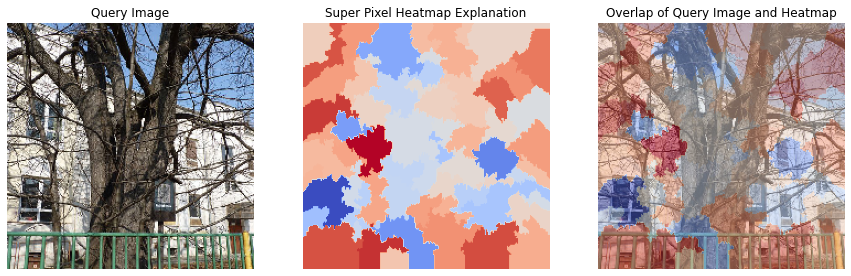

In [54]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb

# index of the image to explain
idx = 0

# 1) Create the Explainer
lm = LimeXAIImageExplainer(imagenet_VGG)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = images.astype(float)
    return np.argmax(imagenet_VGG.predict(images),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(imagenet_x_data[idx].astype(int), classifier_fn, num_samples=500)

# 4) Plot the results
lm.plot_lime_values(imagenet_x_data[idx].astype(int), explanation)

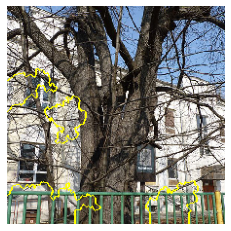

In [55]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
plt.axis('off');

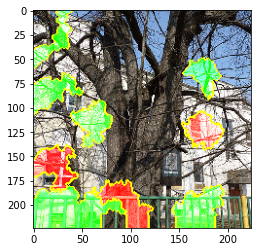

In [56]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2);

# ILORE

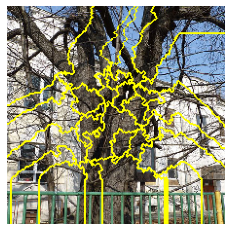

In [104]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb
image = imagenet_x_data[0].astype(int)
"""
First you need to define the segmentation function to use, in this example we will use
quickshift from skimage. It is foundamental to tune the parameters of the segmentation in
order to have a good one. It is recommentded to print an example of just only the segmentation
to see if it works for that kind of image
For quickshift we have to tune these two parameters below
kernel_size : float, optional
    Width of Gaussian kernel used in smoothing the
    sample density. Higher means fewer clusters.
max_dist : float, optional
    Cut-off point for data distances.
    Higher means fewer clusters.
"""
def segmentation_fn(image):
    return quickshift(image, kernel_size=15, max_dist=15)
plt.imshow(mark_boundaries(image/255,segmentation_fn(image)))
plt.axis('off');

In [105]:
from externals.LOREM.ilorem import ILOREM

# Predict Function of our black box. 
# !!!IMPORTANT!!! It needs to take as input a list of RGB images and return an array of class indices of shape (-1,1)
def classifier_fn(images):
    images = np.array(images,dtype=float)
    return np.argmax(imagenet_VGG(images).numpy(),axis=1).reshape(-1,1)

# Create the explainer
explainer = ILOREM(bb_predict = classifier_fn, 
                   class_name='class', 
                   class_values = range(1000), 
                   segmentation_fn=segmentation_fn,
                   verbose=True)

In [106]:
exp = explainer.explain_instance(imagenet_x_data[0,:].astype(int), num_samples=100, use_weights=True, metric='cosine')

generating neighborhood - lime
synthetic neighborhood class counts {442: 1, 448: 1, 517: 36, 540: 6, 682: 1, 698: 2, 716: 16, 755: 35, 812: 2}
learning local decision tree
retrieving explanation


In [107]:
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))

e = {
	r = { 4 > 0.50, 11 > 0.50, 3 > 0.50, 7 > 0.50, 22 > 0.50, 9 > 0.50, 0 > 0.50 } --> { class: 716 }
	c = { { 4 <= 0.50 } --> { class: 755 }, { 22 <= 0.50 } --> { class: 517 }, { 11 <= 0.50 } --> { class: 755 }, { 7 <= 0.50 } --> { class: 517 }, { 9 <= 0.50 } --> { class: 517 }, { 0 <= 0.50 } --> { class: 540 } }    
}


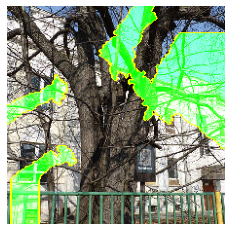

In [108]:
img2show, mask = exp.get_image_rule(hide_rest=False, num_features=None, min_importance=0.0)
plt.imshow(mark_boundaries(img2show/255,mask))
plt.axis('off');

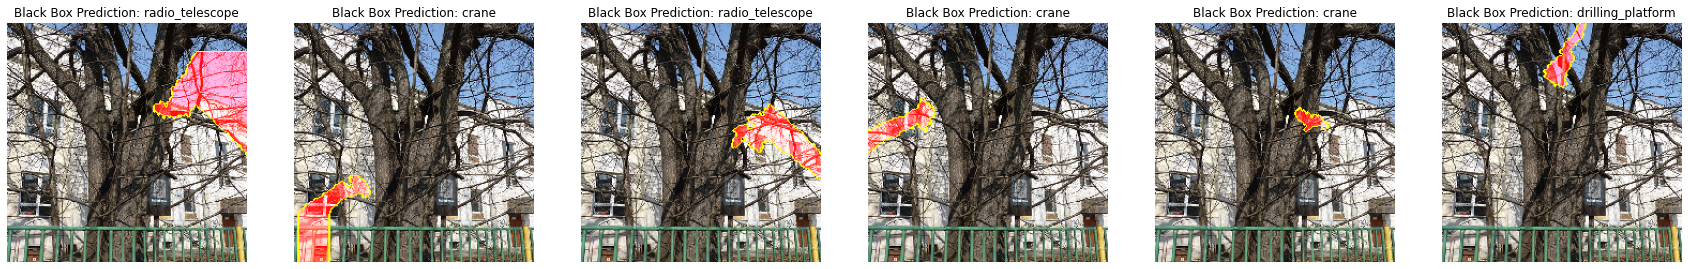

In [110]:
imgs2show, masks, coutcomes = exp.get_image_counterfactuals(hide_rest=False, num_features=None, min_importance=0.0)
if len(imgs2show)==1:
    plt.imshow(mark_boundaries(imgs2show[0]/255, masks[0]))
    plt.title('Black Box Prediction: '+str(coutcomes[0]))
    plt.axis('off')
else:
    F, ax = plt.subplots(1,len(imgs2show),figsize=(5*len(imgs2show),5))
    for i in range(len(imgs2show)):
        ax[i].imshow(mark_boundaries(imgs2show[i]/255, masks[i]))
        ax[i].set_title('Black Box Prediction: '+imagenet_map[str(coutcomes[i])][1])
        ax[i].axis('off')

In [111]:
#disable eager execution in tensorflow 2.x for faster training time
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# ABELE

Abele uses an autoencoder in its explanation procedure, there are two way you can build one: 
* Using ABELE method
* Building you own

### Using ABELE `get_autoencoder` method: 

`get_autoencoder` creates the autoencoder class to train

* X: dataset to use to train the ae 
* ae_name: type of the autoencoder to train, only adversarial autoencoder (aae) and variational autoencoder (vae) are supported
* path_aemodels: path where to save the weights
* dataset: name of the dataset to use

OPTIONAL:

* latent_dim: latent space dimension (only use if dataset is custom)
* hidden_dim: hidden dimension of the autoencoders layers (ex: 1024 will create two layers of 1024 hidden units) (only use if dataset is custom)
* num_filters: number of filter to use in the convolutional layers (only use if dataset is custom)

### Building a customized autoencoder: 

If you want to use your own, you need to implement an autoencoder class with these funtioncs inside:
- self.encode: take the image as input and return the latent space vector
- self.decode: take a vector as input and return the reconstructed image
- self.latent_dim: int representing the number of dimensions of the latent space
- self.discriminator: (only for adversarial autoencoders) take a vector as input and output a class label

In [112]:
from externals.ABELE.experiments.exputil import get_autoencoder

In [114]:
import os
# The type of autoencoder to train ['aae','vae']
ae_name = 'aae'
# This script will save the models weights in the folder ./path/models/abele/dataset/ae_name
path = './'
dataset = 'imagenet'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
if not os.path.exists(path_aemodels):
    os.makedirs(path_aemodels)

In [115]:
# HYPER-PARAMETERS
#define the epochs and the batch size for which the autoencoder will be trained
epochs = 2000
batch_size = 64
#Print training summary every sample_interval step
sample_interval = 50

In [ ]:
#  Get_autoencoder create the autoencoder class to train
X_test = imagenet_x_data 
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset, hidden_dim=50, latent_dim=10, use_rgb=True)

ae.fit(X_test, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
# save the weights in the oath specified before
ae.save_model()
# save also some sample images to test if the autoencoderis trained correctly
ae.sample_images(epochs)

In [3]:
import sys
import os
from externals.ABELE.experiments.exputil import get_autoencoder
from externals.ABELE.experiments.exputil import get_dataset
import shap
import warnings
warnings.filterwarnings('ignore')

#disable eager execution in tensorflow 2.x for faster training time
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# The dataset to use for training
# if you prefer to use yours load the data in two vector X_data and Y_data, set dataset variable to a custom name and custom_dataset to True
dataset = 'mnist'
custom_dataset = False
if not custom_dataset:
    _, _, X_test, Y_test, use_rgb = get_dataset(dataset)

# The type of autoencoder to train ['aae','vae']
ae_name = 'aae'

# This script will save the models weights in the folder ./path/models/abele/dataset/ae_name
path = './'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
if not os.path.exists(path_aemodels):
    os.makedirs(path_aemodels)

# HYPER-PARAMETERS
#define the epochs and the batch size for which the autoencoder will be trained
epochs = 2000
batch_size = 64
#Print training summary every sample_interval step
sample_interval = 50

"""
 Get_autoencoder create the autoencoder class to train
 Arguments: 
    X: dataset to use to train the ae 
    ae_name: type of the autoencoder to train, only adversarial autoencoder (aae) and variational autoencoder (vae) are supported
    path_aemodels: path where to save the weights
    dataset: name of the dataset to use
    OPTIONAL:
    latent_dim: latent space dimension (only use if dataset is custom)
    hidden_dim: hidden dimension of the autoencoders layers (ex: 1024 will create two layers of 1024 hidden units) (only use if dataset is custom)
    num_filters: number of filter to use in the convolutional layers (only use if dataset is custom)
"""
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset)

""" Fit method
 Arguments: 
    X: Dataset to use to train the ae
    epochs: Epochs to train
    batch_size
    sample interval (see before)
"""
ae.fit(X_test, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
# save the weights in the oath specified before
ae.save_model()
# save also some sample images to test if the autoencoderis trained correctly
ae.sample_images(epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              5120      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 530,433
Trainable params: 530,433
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
__________________________________________________________________________________________________


generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	75    	0.496654	0.496654	0.496654
1  	48    	0.542373	0.248846	0.993152
2  	53    	0.70125 	0.472628	0.993152
3  	34    	0.85876 	0.098737	0.993152
4  	43    	0.95258 	0.244057	0.993152
5  	55    	0.91583 	0.257868	0.993256
6  	28    	0.96847 	0.259162	0.993256
7  	37    	0.954369	0.177466	0.993256
8  	46    	0.960842	0.232478	0.993256
9  	46    	0.923655	0.0877734	0.993256
10 	40    	0.95416 	0.0720537	0.993296
11 	46    	0.985665	0.496329 	0.993296
12 	43    	0.978887	0.437006 	0.993296
13 	42    	0.956984	0.156114 	0.993296
14 	44    	0.971537	0.413424 	0.993296
15 	42    	0.968575	0.176225 	0.993297
16 	42    	0.946882	0.283662 	0.993306
17 	46    	0.967689	0.187155 	0.993306
18 	52    	0.95901 	0.0307943	0.993306
19 	45    	0.928876	0.447075 	0.993306
20 	42    	0.966321	0.0255794	0.993306
21 	44    	0.978401	0.484675 	0.993306
22 	39    	0.993255	0.991052 	0.993306
23 	47    	0.963918	0.161929 	0.993306
24 	4

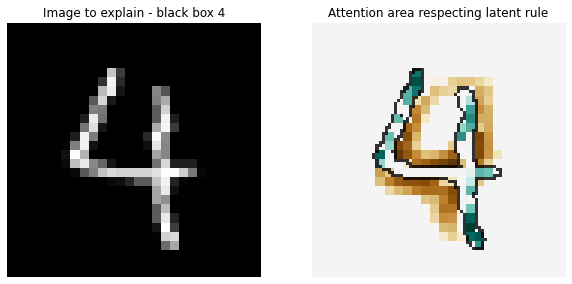

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform

from externals.ABELE.ilore.ilorem import ILOREM
from externals.ABELE.ilore.util import neuclidean
from externals.ABELE.experiments.exputil import get_dataset
from externals.ABELE.experiments.exputil import get_autoencoder

import warnings
warnings.filterwarnings('ignore')

random_state = 0
dataset = 'imagenet' 
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae' 
path = './' 
path_aemodels = path + 'models/abele/%s/%s/' % (dataset, ae_name)
bb = imagenet_VGG

# defining a functions for bb to return the class index value
def bb_predict(X):
    X = X.astype(float)
    Y = bb.predict(X)   
    return np.argmax(Y, axis=1)

# load data
_, _, X_test, Y_test, _ = get_dataset(dataset)
use_rgb = True

# load auto encoder
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset)
ae.load_model()

class_name = 'class'
class_values = ['%s' % i for i in range(len(np.unique(Y_test)))]

# index Image 2 Explain
i2e = 24
img = X_test[i2e]
# time
start = time.time()

# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
explainer = ILOREM(bb_predict, 
                   class_name, 
                   class_values, 
                   neigh_type='hrg', 
                   ocr=0.1, #other class ratio in the neighbourhood
                   kernel_width=None, 
                   kernel=None, 
                   autoencoder=ae, 
                   use_rgb=use_rgb, 
                   filter_crules=True, 
                   random_state=random_state, 
                   verbose=True, 
                   valid_thr=0.5,
                   alpha1=0.5, 
                   alpha2=0.5, 
                   ngen=100, 
                   mutpb=0.2, 
                   cxpb=0.5, 
                   tournsize=3, 
                   halloffame_ratio=0.1)

#generate explanation
"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain_instance(img, num_samples=300, use_weights=True, metric=neuclidean)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))
print('--------------------------')
print('bb prediction of the image: ',exp.bb_pred,'dt prediction: ',exp.dt_pred,'fidelity: ',exp.fidelity)
print('latent space representation: ',exp.limg)

"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.get_image_rule(features=None, samples=400)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

Green Points are the ones critical for the preditction, also called exemplars

Yellow points are the ones who change class if activated

White Points are do-nothing points

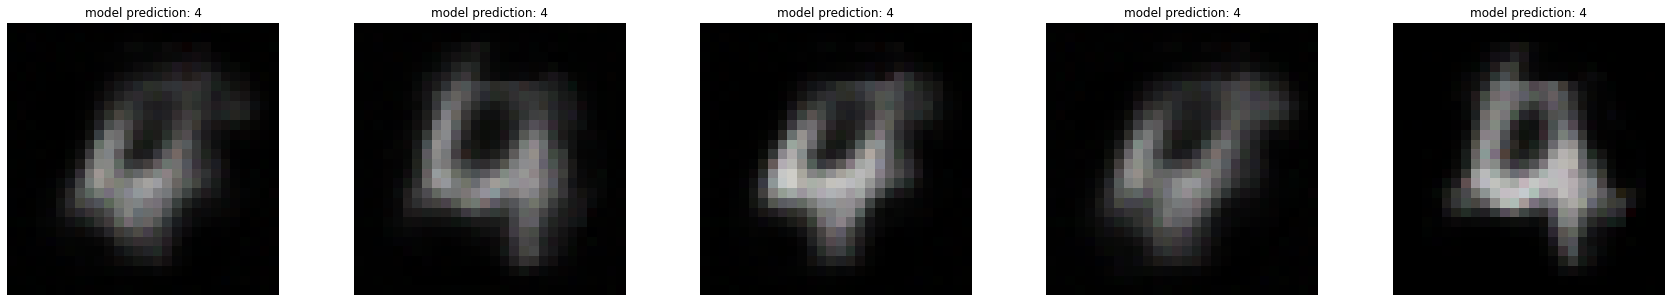

In [5]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5] number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features int he latent space to use, if none use all
"""
proto = exp.get_prototypes_respecting_rule(num_prototypes=5)

F, ax = plt.subplots(1,5,figsize=(30,5))
for i in range(5):
    ax[i].imshow(proto[i]/255)
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(proto[i])[0]))

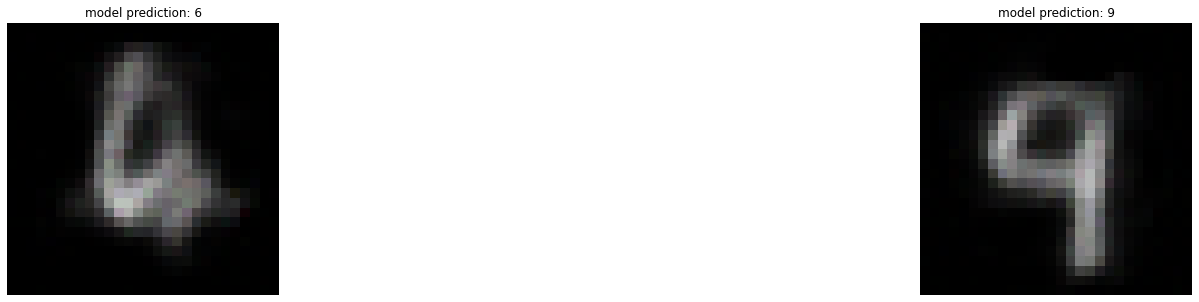

In [8]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.get_counterfactual_prototypes()

F, ax = plt.subplots(1,len(counter),figsize=(30,5))
for i in range(len(counter)):
    ax[i].imshow(counter[i]/255)
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(counter[i])[0]))

#### Custom model example

In [9]:
import sys
import os
from externals.ABELE.experiments.exputil import get_autoencoder
from externals.ABELE.experiments.exputil import get_dataset
import shap
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

#disable eager execution for faster training time
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# The dataset to use for training
# if you prefer to use yours load the data in two vector X_data and Y_data, set dataset variable to a custom name and custom_dataset to True
dataset = 'custom'
custom_dataset = True
if not custom_dataset:
    _, _, X_test, Y_test, use_rgb = get_dataset(dataset)

(_, _), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_test = (X_test/255).reshape(-1,28,28,1)

# The type of autoencoder to train ['aae','vae']
ae_name = 'aae'

# This script will save the models weights in the folder ./path/models/abele/dataset/ae_name
path = './'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
if not os.path.exists(path_aemodels):
    os.makedirs(path_aemodels)

# HYPER-PARAMETERS
#define the epochs and the batch size for which the autoencoder will be trained
epochs = 2000
batch_size = 64
#Print training summary every sample_interval step
sample_interval = 50

"""
 Get_autoencoder create the autoencoder class to train
 Arguments: 
    X: dataset to use to train the ae 
    ae_name: type of the autoencoder to train, only adversarial autoencoder (aae) and variational autoencoder (vae) are supported
    path_aemodels: path where to save the weights
    dataset: name of the dataset to use
    OPTIONAL:
    latent_dim: latent space dimension (only use if dataset is custom)
    hidden_dim: hidden dimension of the autoencoders layers (ex: 1024 will create two layers of 1024 hidden units) (only use if dataset is custom)
    num_filters: number of filter to use in the convolutional layers (only use if dataset is custom)
"""
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset, latent_dim=10, hidden_dim=128, num_filters=16, use_rgb=False)
""" Fit method
 Arguments: 
    X: Dataset to use to train the ae
    epochs: Epochs to train
    batch_size
    sample interval (see before)
"""
ae.fit(X_test, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
# save the weights in the path specified before
ae.save_model()
# save some sample images of the final epoch to test if the autoencoder has trained correctly
ae.sample_images(epochs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               1408      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________
Model: "model_5"
__________________________________________________________________________________________________
La

### 2) Generating Explanations

./models/abele/custom/aae/
custom
generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	250   	0.496654	0.496654	0.496654
1  	145   	0.550348	0.10005 	0.992578
2  	162   	0.716795	0.139035	0.993307
3  	125   	0.871267	0.302425	0.993305
4  	155   	0.938709	0.124621	0.993305
5  	154   	0.949121	0.217586	0.993305
6  	127   	0.953197	0.388074	0.993305
7  	141   	0.938818	0.0443783	0.993305
8  	129   	0.944101	0.201488 	0.993305
9  	154   	0.933328	0.309299 	0.993305
10 	143   	0.937871	0.175121 	0.993305
gen	nevals	avg	min	max
0  	250   	0.5	0.5	0.5
1  	156   	0.525098	0.346948	0.985487
2  	147   	0.575744	0.344826	0.988324
3  	154   	0.692635	0.312554	0.98873 
4  	139   	0.833252	0.304286	0.98873 
5  	140   	0.919045	0.410055	0.98873 
6  	156   	0.937702	0.481746	0.989441
7  	161   	0.936419	0.354695	0.989441
8  	166   	0.914068	0.426831	0.989441
9  	151   	0.942515	0.425822	0.989444
10 	160   	0.926974	0.399442	0.989444
synthetic neighborhood class counts {'0': 32, '1':

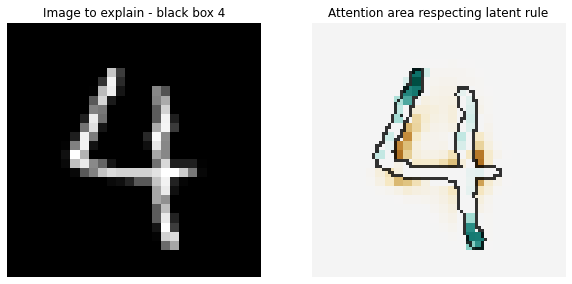

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform
#disable eager execution in tensorflow 2.x for faster training time
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from externals.ABELE.ilore.ilorem import ILOREM
from externals.ABELE.ilore.util import neuclidean

from externals.ABELE.experiments.exputil import get_dataset
from externals.ABELE.experiments.exputil import get_autoencoder

import warnings
warnings.filterwarnings('ignore')

random_state = 0
dataset = 'custom' 
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae' 
path = './' 
path_aemodels = path + 'models/abele/%s/%s/' % (dataset, ae_name)
bb = tf.keras.models.load_model("./models/cnn_simple_mnist_no_pickle")
# defining a functions for bb to return the class index value
def bb_predict(X):
    X = X.astype(float)
    Y = bb.predict(X)   
    return np.argmax(Y, axis=1)

# load data
dataset = 'custom'
(_, _), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_test = (X_test/255).reshape(-1,28,28,1)
use_rgb=False

print(path_aemodels)
print(dataset)
# load auto encoder
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset, latent_dim=10, hidden_dim=128, num_filters=16, use_rgb=use_rgb)
ae.load_model()

class_name = 'class'
class_values = ['%s' % i for i in range(len(np.unique(Y_test)))]

# index Image 2 Explain
i2e = 24
img = X_test[i2e]
# time
start = time.time()
# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
explainer = ILOREM(bb_predict, 
                   class_name, 
                   class_values, 
                   neigh_type='hrg',
                   ocr=0.1,
                   kernel_width=None, 
                   kernel=None, 
                   autoencoder=ae, 
                   use_rgb=use_rgb, 
                   filter_crules=True, 
                   random_state=random_state, 
                   verbose=True, 
                   valid_thr=0.5,
                   alpha1=0.5, 
                   alpha2=0.5,
                   metric=neuclidean, 
                   ngen=10, 
                   mutpb=0.2, 
                   cxpb=0.5, 
                   tournsize=3, 
                   halloffame_ratio=0.1)

"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain_instance(img, num_samples=1000, use_weights=True, metric=neuclidean)
# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))
print('--------------------------')
print('bb prediction of reconstructed image: ',exp.bb_pred,'dt prediction: ',exp.dt_pred,'fidelity: ',exp.fidelity)
print('latent space representation: ',exp.limg)

"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.get_image_rule(features=None, samples=400)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

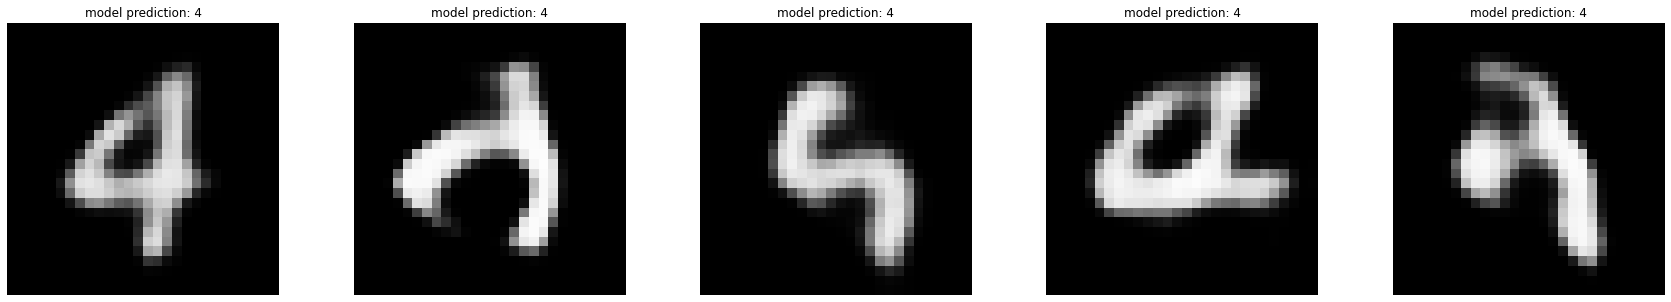

In [34]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5] number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features int he latent space to use, if none use all
"""
proto = exp.get_prototypes_respecting_rule(num_prototypes=5)

F, ax = plt.subplots(1,5,figsize=(30,5))
for i in range(5):
    ax[i].imshow(proto[i])
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(rgb2gray(proto[0])[np.newaxis,:,:,np.newaxis])[0]))

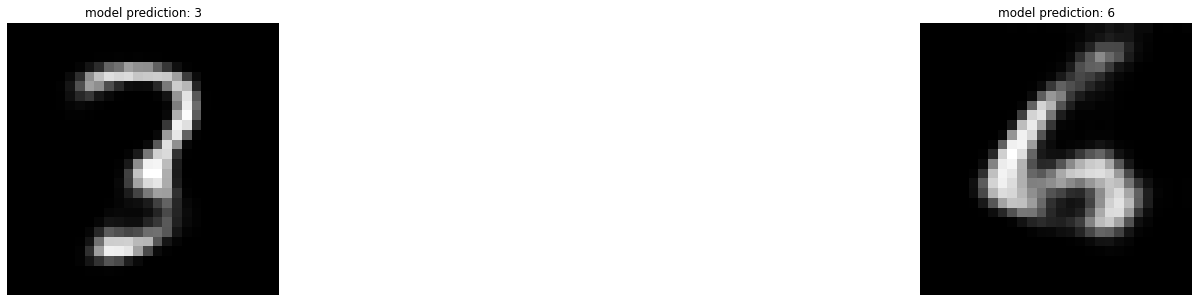

In [35]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.get_counterfactual_prototypes()

F, ax = plt.subplots(1,len(counter),figsize=(30,5))
for i in range(len(counter)):
    ax[i].imshow(counter[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(counter[i][np.newaxis,:])[0]))